# ANN 돌리기


In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


/home/ssm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


#### 1. 2023-2023 1년치 길이 데이터 
#### 2. 2019-2023 4년치 길이 데이터


In [2]:
df = pd.read_csv('./data/2023-2023_all.csv')
print(df.head())

df['일시'] = df['Unnamed: 0']
df = df.drop(columns='Unnamed: 0')
df['일시'] = pd.to_datetime(df['일시'])
df.set_index('일시',inplace=True)
data = df
data

   Unnamed: 0  평균 수온(°C)
0  2023-01-01       14.1
1  2023-01-02       14.1
2  2023-01-03       14.1
3  2023-01-04       14.0
4  2023-01-05       13.9


,평균 수온(°C)
일시,
2023-01-01,14.1
2023-01-02,14.1
2023-01-03,14.1
2023-01-04,14.0
2023-01-05,13.9
...,...
2023-12-27,15.5
2023-12-28,15.2
2023-12-29,15.3


In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1
    # df 365개
    # trn_df 365-20 = 345개
    # 345 - 15 - 5 + 1 = 326개

  def __getitem__(self, i):
    idx = (i + self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx + self.forecast_size]

  # def __getitem__(self, i): # 맞는지?
  #   idx = ((i*self.forecast_size) + self.lookback_size)
  #   look_back = self.data[i*self.forecast_size : idx]
  #   forecast = self.data[idx : idx + self.forecast_size]

    # 0 14 / 15 19
    # 1 15 / 16 20
    # 2 16

    # 0 14 / 15 19
    # 5 19 / 20 24
    # 10 24 / 25 29



    return look_back, forecast

## 하이퍼 파라미터
### look_back = 앞에 몇 개 보고 예측할꺼냐
### forecast = 몇개 볼 거냐, 학습할때 몇개보고 몇 개 예측할때의 예측
### predict_size = 최종 tst_data를 며칠 예측할꺼냐
### 스케일링 = 유무


- predict_size  =  15 30 60 90 ### 정리를 할 때(발표를 할 때 , 실험은 다 함)
- look_back = 5 15 30 60 90
- forecast = 1 5 15 30
- scaed = O , X

- shift 방식은? --> ex : 6개 나오고 1칸 or 6개 나오고 5칸
-- 방법론이 많다. 겹치는 부분이 평균내기도 하고, 윈도우 사이즈만큼만 가라(겹치지말고 칸씩만 움직이면서 진행-- 추천하시는 방법)
- 1칸씩 가기에는 너무 멀다 경우에 한꺼번에 여러칸을 간다.

In [26]:
print(data)
print(trn_df.shape)
print(tst_df)
print(tst_df.shape)

            평균 수온(°C)
일시                   
2023-01-01       14.1
2023-01-02       14.1
2023-01-03       14.1
2023-01-04       14.0
2023-01-05       13.9
...               ...
2023-12-27       15.5
2023-12-28       15.2
2023-12-29       15.3
2023-12-30       14.4
2023-12-31       14.3

[365 rows x 1 columns]
(345,)
[16.6 16.8 18.  17.9 17.8 17.6 17.2 16.9 16.9 16.8 16.7 16.4 16.4 16.5
 15.9 15.5 15.5 15.7 15.8 15.8 15.3 15.8 15.7 14.9 14.9 15.1 15.6 15.4
 15.  15.  15.5 15.2 15.3 14.4 14.3]
(35,)


In [19]:
print(len(trn_Ods))     # 345 - 15 -5 + 1 = 326
print(len(tst_Ods))     # 35 - 15 -5 + 1 = 16

326
16


In [16]:
print(next(iter(trn_Odl))[0].shape)
print(next(iter(tst_Odl))[0].shape)

torch.Size([32, 15])
torch.Size([16, 15])


In [ ]:
next(iter(tst_Odl))

In [22]:
print(next(iter(trn_Odl))[1].shape)
print(next(iter(tst_Odl))[1].shape)


torch.Size([32, 5])
torch.Size([16, 5])


In [4]:
# 바꿔야 하는 인자 => 동적으로 변경 가능하도록 수정 예정
pred_size = 20
lookback_size = 15
forecast_size = 5

lr = 0.0001

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-pred_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-pred_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

trn_df = data[:-pred_size].to_numpy(dtype=np.float32).flatten()
tst_df = data[-pred_size - lookback_size:].to_numpy(dtype=np.float32).flatten()

### 스케일 안한 케이스
trn_Ods = TimeSeriesDataset(trn_df, lookback_size, forecast_size)
tst_Ods = TimeSeriesDataset(tst_df, lookback_size, forecast_size)

trn_Odl = DataLoader(trn_Ods, batch_size=32, shuffle=True)
tst_Odl = DataLoader(tst_Ods, batch_size=pred_size, shuffle=False)

#### 스케일 한 케이스
trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = DataLoader(tst_ds, batch_size=pred_size, shuffle=False)

In [6]:
next(iter(tst_dl))[0].shape

torch.Size([16, 15])

{
-    "input_dim": "feature.shape[1]",
-   "layers": [64,32, 5],
-    "activations": "tanh","tanh"  스케일링하면 sigmoid
-    "dropout": 0.0, X
-    "lr": [0.01, 0.001 , 0.0001 , 0.00001]
-    "epochs": [500 1000 2000 3000]
-    "batch_size": 128 256 512 1024
-    "criterion" : "nn.MSELoss()" X 
-    "optimizer" : "Adam" "AdamW" X
}

In [5]:
class Net(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return F.relu(x) # scaled 시 2가지 케이스
  
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(lookback_size, forecast_size, 512)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=lr)

pbar = trange(2000)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_Odl: # 여기 2가지 케이스
    # 15개, 5개 in 326개
    x, y = x.to(device), y.to(device)
    p = net(x)    # 5개의 predict output
    optim.zero_grad()
    loss = F.mse_loss(p, y)   # pred 와 target 차이
    loss.backward()
    optim.step()
    trn_loss += loss.item() * len(y)
  trn_loss = trn_loss / len(trn_Ods) # 여기 2가지 케이스

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_Odl)) # 여기 2가지 케이스
    x, y = x.to(device), y.to(device)
    p = net(x)
    print(x.shape)
    print(p.shape)
    tst_loss = F.mse_loss(p, y) 
    y = y.cpu()
    p = p.cpu()
    


    # mape와 mae 계산 
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)


  # pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item(), 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})#, })
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

In [9]:
p.shape

torch.Size([16, 5])

In [10]:
p

tensor([[15.9576, 16.3530,  0.0000, 16.2906, 16.3239],
        [15.4188, 15.7179,  0.0000, 15.7791, 15.8262],
        [15.3952, 15.5221,  0.0000, 15.5337, 15.5895],
        [15.5695, 15.6087,  0.0000, 15.5279, 15.4285],
        [15.5581, 15.6994,  0.0000, 15.3815, 15.3014],
        [15.6522, 15.7852,  0.0000, 15.4307, 15.4757],
        [15.1646, 15.2114,  0.0000, 15.1232, 15.2044],
        [15.5203, 15.5528,  0.0000, 15.3544, 15.4237],
        [15.4652, 15.5095,  0.0000, 15.4558, 15.3912],
        [14.6551, 14.8642,  0.0000, 15.0115, 15.0692],
        [14.7045, 15.0223,  0.0000, 14.9124, 15.1552],
        [15.1170, 15.2021,  0.0000, 15.2155, 15.1976],
        [15.4897, 15.6016,  0.0000, 15.4351, 15.2210],
        [15.2218, 15.5121,  0.0000, 15.2270, 15.2080],
        [14.9519, 15.1255,  0.0000, 15.0249, 15.1709],
        [14.8876, 14.9639,  0.0000, 14.9760, 15.0810]])

In [18]:
net.eval()
with torch.inference_mode():
    x, y = next(iter(tst_Odl)) # 여기 2가지 케이스
    x, y = x.to(device), y.to(device)
    p = net(x)
print(x)
print()
print(y)
# y = scaler.inverse_transform(y.cpu())
# p = scaler.inverse_transform(p.cpu())

y = y.cpu()
p = p.cpu()
print(y.shape, p.shape)

# y = np.concatenate([y[:,0], y[-1,1:]])
# p = np.concatenate([p[:,0], p[-1,1:]])

tensor([[16.6000, 16.8000, 18.0000, 17.9000, 17.8000, 17.6000, 17.2000, 16.9000,
         16.9000, 16.8000, 16.7000, 16.4000, 16.4000, 16.5000, 15.9000],
        [16.8000, 18.0000, 17.9000, 17.8000, 17.6000, 17.2000, 16.9000, 16.9000,
         16.8000, 16.7000, 16.4000, 16.4000, 16.5000, 15.9000, 15.5000],
        [18.0000, 17.9000, 17.8000, 17.6000, 17.2000, 16.9000, 16.9000, 16.8000,
         16.7000, 16.4000, 16.4000, 16.5000, 15.9000, 15.5000, 15.5000],
        [17.9000, 17.8000, 17.6000, 17.2000, 16.9000, 16.9000, 16.8000, 16.7000,
         16.4000, 16.4000, 16.5000, 15.9000, 15.5000, 15.5000, 15.7000],
        [17.8000, 17.6000, 17.2000, 16.9000, 16.9000, 16.8000, 16.7000, 16.4000,
         16.4000, 16.5000, 15.9000, 15.5000, 15.5000, 15.7000, 15.8000],
        [17.6000, 17.2000, 16.9000, 16.9000, 16.8000, 16.7000, 16.4000, 16.4000,
         16.5000, 15.9000, 15.5000, 15.5000, 15.7000, 15.8000, 15.8000],
        [17.2000, 16.9000, 16.9000, 16.8000, 16.7000, 16.4000, 16.4000, 16.5

In [12]:
preds = []

# 훈련 데이터에서 마지막의 input(15개), output(5개) 값을 가져옴
x, y = trn_Ods[len(trn_Ods)-1]
print(f'x: {x}, y: {y}')

# input data를 PyTorch tensor로 변환
x = torch.tensor(x)
# print(np.concatenate([x, y]).shape , x.shape, y.shape)

net.eval()
# ex) lookback_size(15) + forecast_size(1) = 16 
# > 병합된 사이즈에서 맨앞의 forecast_size만큼 제외 
# > 구하고자 하는 forecast_size 값 설정하면 됨
for _ in range(int(pred_size/forecast_size)): #우리가 예측할 날짜 / forecast_size
  # input data에 현재 출력값을 이어붙이고 window_size만큼 최신 데이터로 유지
  x = np.concatenate([x, y])[-lookback_size:] 
  # x = 20개[-15:]
  # x 는 15개


  # 예측을 위해 모델을 추론(평가) 모드로 설정
  with torch.inference_mode():
    # 예측을 수행한 결과값을 CPU에 올림
    y = net(torch.tensor(x).cuda()).cpu()
    print(f'y: {y}')
    ## y = 15 , 1 # 15일보고 1개 예측
    ## y = 15 , 5 # 15일보고 5개 예측
  preds.append(y)

print(f'len(preds): {len(preds)}')
# len(preds) = 4 개 (for문 range만큼)

preds = np.concatenate(preds) # 예측 결과값을 하나의 Numpy 배열로 병합
print(f'preds: {preds}')
# 4개(5개씩)를 합치므로 4x5 = 20개

net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_Odl)) # 여기 2가지 케이스
  x, y = x.to(device), y.to(device)
y = y.cpu()
p = p.cpu()

x: [15.2 15.2 15.5 16.5 17.8 16.6 16.8 18.  17.9 17.8 17.6 17.2 16.9 16.9
 16.8], y: [16.7 16.4 16.4 16.5 15.9]
y: tensor([ 0.0000,  0.0000, 16.0315, 16.0448, 16.0962])
y: tensor([ 0.0000,  0.0000, 16.5122, 15.5633, 15.7552])
y: tensor([ 0.0000,  0.0000, 12.1888, 12.7652, 12.7266])
y: tensor([0.0000, 0.0000, 9.2519, 9.3837, 8.5574])
len(preds): 4
preds: [ 0.        0.       16.031519 16.044752 16.096214  0.        0.
 16.512224 15.563257 15.755164  0.        0.       12.188831 12.765179
 12.726628  0.        0.        9.251853  9.38367   8.557447]


In [12]:
print(preds)

[16.203903 16.46556  16.673374 16.805906 16.858335 17.058403 17.137905
 17.213787 17.421366 17.617924 17.877705 18.11665  18.283531 18.41277
 18.473358 18.5568   18.685833 18.838732 19.044186 19.242672]


In [13]:
print(p.shape)
print(preds.shape)
print(y.shape)

torch.Size([20, 1])
(20,)
torch.Size([20, 1])


In [20]:
y = y.numpy()

In [21]:
y = y.flatten()

In [16]:
preds, y

(array([ 0.      ,  0.      , 16.031519, 16.044752, 16.096214,  0.      ,
         0.      , 16.512224, 15.563257, 15.755164,  0.      ,  0.      ,
        12.188831, 12.765179, 12.726628,  0.      ,  0.      ,  9.251853,
         9.38367 ,  8.557447], dtype=float32),
 array([15.5, 15.5, 15.7, 15.8, 15.8, 15.5, 15.7, 15.8, 15.8, 15.3, 15.7,
        15.8, 15.8, 15.3, 15.8, 15.8, 15.8, 15.3, 15.8, 15.7, 15.8, 15.3,
        15.8, 15.7, 14.9, 15.3, 15.8, 15.7, 14.9, 14.9, 15.8, 15.7, 14.9,
        14.9, 15.1, 15.7, 14.9, 14.9, 15.1, 15.6, 14.9, 14.9, 15.1, 15.6,
        15.4, 14.9, 15.1, 15.6, 15.4, 15. , 15.1, 15.6, 15.4, 15. , 15. ,
        15.6, 15.4, 15. , 15. , 15.5, 15.4, 15. , 15. , 15.5, 15.2, 15. ,
        15. , 15.5, 15.2, 15.3, 15. , 15.5, 15.2, 15.3, 14.4, 15.5, 15.2,
        15.3, 14.4, 14.3], dtype=float32))

In [22]:
plt.title(f"Neural Network, MAPE:{mape(preds,y):.4f}, MAE:{mae(preds,y):.4f}")
plt.plot(range(pred_size), y, label="True")
plt.plot(range(pred_size), preds, label="Prediction")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (20,) (80,) 

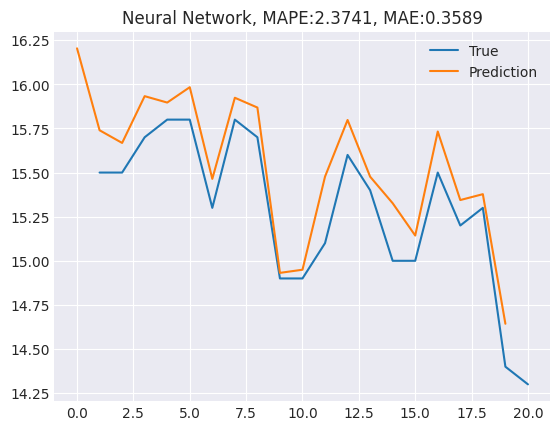

In [17]:
plt.title(f"Neural Network, MAPE:{mape(p, y):.4f}, MAE:{mae(p, y):.4f}")
plt.plot(range(1, pred_size+1), y, label="True")
plt.plot(range(pred_size), p, label="Prediction")
plt.legend()
plt.show()

In [29]:
print(mape(p[1:], y[:-1]))

tensor(0.3107)


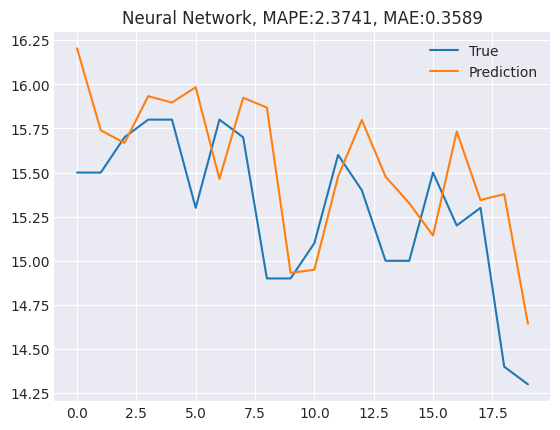

In [18]:
plt.title(f"Neural Network, MAPE:{mape(p, y):.4f}, MAE:{mae(p ,y):.4f}")
plt.plot(range(len(y)), y, label="True")
plt.plot(range(len(p)), p, label="Prediction")
plt.legend()
plt.show()